In [41]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics.functional import multiclass_f1_score
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
import datetime
import tqdm


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# defines the number of processes that loads the data, idealy set according to the number of the cores available in cpu
NUM_WORKERS = min(4, os.cpu_count()) if DEVICE == "cpu" else 2
BATCH_SIZE = 32;
IMAGE_SIZE = 224
PATH = "/content/drive/MyDrive/Ai Project/CCMT_FInal Dataset";
TRAIN_RATIO = 0.95
layersToTrain = 10;


In [5]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
    ])

full_dataset = datasets.ImageFolder(root=PATH, transform=transform)

In [6]:
classes = full_dataset.classes
num_classes = len(classes)

In [7]:
train_size = int(TRAIN_RATIO * len(full_dataset))
test_size = len(full_dataset) - train_size

# Split the dataset into training and testing sets
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers = NUM_WORKERS)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers = NUM_WORKERS)

In [8]:
resnet = models.resnet50(pretrained=True)

resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
#loading model states from a checkpoint
resnet = resnet.to(DEVICE)
checkpoint = torch.load('/content/drive/MyDrive/Ai Project/cropsClassifierCheckpoints/checkpoint_weights.pth',map_location=torch.device(DEVICE
                                                                                                                           ));
resnet.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

In [10]:
def calculateMisclassificationPercentage(logits, labels):
    """
    Calculate the percentage of misclassification given logits and truth labels.

    Parameters:
        logits (torch.Tensor): The predicted logits.
        labels (torch.Tensor): The ground truth labels.

    Returns:
        float: The percentage of misclassification.
    """
    _, predicted_indices = torch.max(logits, 1)
    _, label_indices = torch.max(labels, 1)

    correct = (predicted_indices == label_indices).sum().item()
    total = label_indices.size(0)

    return ((1 - (correct / total)) * 100)


In [113]:
def evaluate_model(model, val_loader, num_classes, criterion):
    model.eval()
    # Variables for storing results
    clsfValidationBatch = []
    evalLoss = 0

    predictions = []
    truth_labels = []
    # Process validation data in batches with tqdm progress bar
    for batchIdx, (inputs, labels) in enumerate(val_loader):

        inputs = inputs.to(DEVICE)
        labels = torch.eye(num_classes)[labels].to(DEVICE)


        outputs = model(inputs)

        for tensor in outputs:
          maxProbIndex = torch.argmax(input=tensor)
          predictions.append(maxProbIndex.item())

        for tensor in labels:
          maxProbIndex = torch.argmax(input=tensor)
          truth_labels.append(maxProbIndex.item())

        # Calculate the criterion loss (classification loss)
        loss = criterion(outputs, labels)
        evalLoss = evalLoss + loss.item()

        # Calculate misclassification percentage
        clsfValidationBatch.append(calculateMisclassificationPercentage(outputs, labels))

    # Calculate F1 Score
    f1_score = multiclass_f1_score(input=torch.tensor(predictions),target=torch.tensor(truth_labels), num_classes=num_classes, average=None)
    # Calculate average loss and misclassification percentage
    evalLoss = evalLoss / (batchIdx + 1)
    clsfValidationLoss = sum(clsfValidationBatch) / (batchIdx + 1)

    return evalLoss, clsfValidationLoss, f1_score, truth_labels, predictions


In [114]:
evalLoss,misCls, f1_score, y_true, y_pred = evaluate_model(resnet,val_loader,num_classes,criterion)

In [115]:
print(f"Eval Loss {evalLoss}")
print(f"Classficiation Loss {misCls}")
print(f"F1 Score {f1_score}")

Eval Loss 0.3967494275420904
Classficiation Loss 14.229166666666666
F1 Score tensor([0.8821, 0.9714, 0.9313, 0.9014, 0.9816, 0.9527, 0.9037, 0.8980, 0.9573,
        0.9710, 0.7143, 0.9383, 0.9167, 0.9574, 0.6813, 0.7559, 0.8983, 0.8929,
        0.5586, 0.4324, 0.7581, 0.3774])
Y True [4, 3, 20, 7, 4, 5, 18, 15, 16, 0, 19, 9, 3, 2, 9, 19, 20, 9, 9, 8, 6, 15, 6, 20, 19, 20, 4, 2, 15, 5, 6, 9, 6, 20, 4, 7, 18, 4, 5, 13, 21, 19, 17, 5, 0, 18, 2, 6, 16, 6, 0, 5, 2, 4, 5, 21, 18, 21, 5, 11, 18, 6, 16, 4, 8, 18, 0, 15, 4, 4, 13, 17, 11, 4, 11, 11, 2, 16, 12, 5, 18, 19, 17, 10, 13, 15, 21, 7, 13, 8, 15, 8, 4, 14, 4, 3, 14, 5, 8, 9, 3, 0, 8, 0, 5, 20, 7, 14, 4, 6, 4, 2, 15, 5, 4, 18, 4, 15, 10, 8, 4, 0, 15, 17, 13, 6, 6, 6, 0, 20, 20, 11, 16, 0, 1, 16, 3, 17, 6, 12, 3, 8, 5, 5, 2, 16, 5, 15, 3, 11, 20, 15, 1, 8, 20, 0, 6, 5, 2, 9, 5, 3, 3, 8, 13, 8, 16, 16, 15, 11, 18, 3, 20, 20, 5, 5, 17, 8, 7, 18, 16, 12, 20, 3, 8, 11, 0, 3, 15, 20, 14, 20, 15, 9, 7, 7, 6, 0, 0, 4, 0, 10, 2, 5, 1, 11, 5, 7, 1

In [134]:
f1Score = f1_score.numpy()

In [136]:
f1Score = f1Score.tolist()

In [138]:
for i in range(len(f1Score)):
  f1Score[i]=round(f1Score[i],2)

In [127]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np

             Category  Values
0  Cashew_anthracnose    0.88
1      Cashew_gumosis    0.97
2      Cashew_healthy    0.93
3   Cashew_leaf miner    0.90
4     Cashew_red rust    0.98


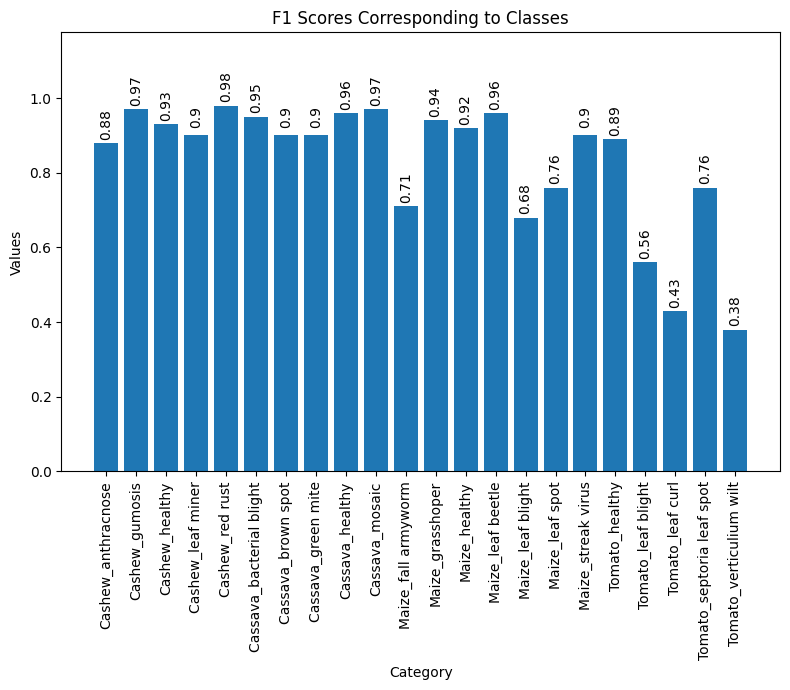

In [160]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i]+0.05,y[i],rotation=90, va='center', ha='center')

data = {
    'Category': classes,
    'Values': f1Score
}
df = pd.DataFrame(data)
print(df.head())

# Plotting the DataFrame values as a bar chart
plt.figure(figsize=(8, 7))
bars = plt.bar(df['Category'], df['Values'], )
plt.xlabel('Category')
plt.ylabel('Values')
plt.title('F1 Scores Corresponding to Classes')
plt.xticks(rotation='vertical')  # Rotate x-axis labels vertically
addlabels(df['Category'],df['Values'])
plt.tight_layout()
plt.ylim(0, max(f1Score) + max(f1Score) * 0.2)
plt.savefig('f1scores.png')

plt.show()

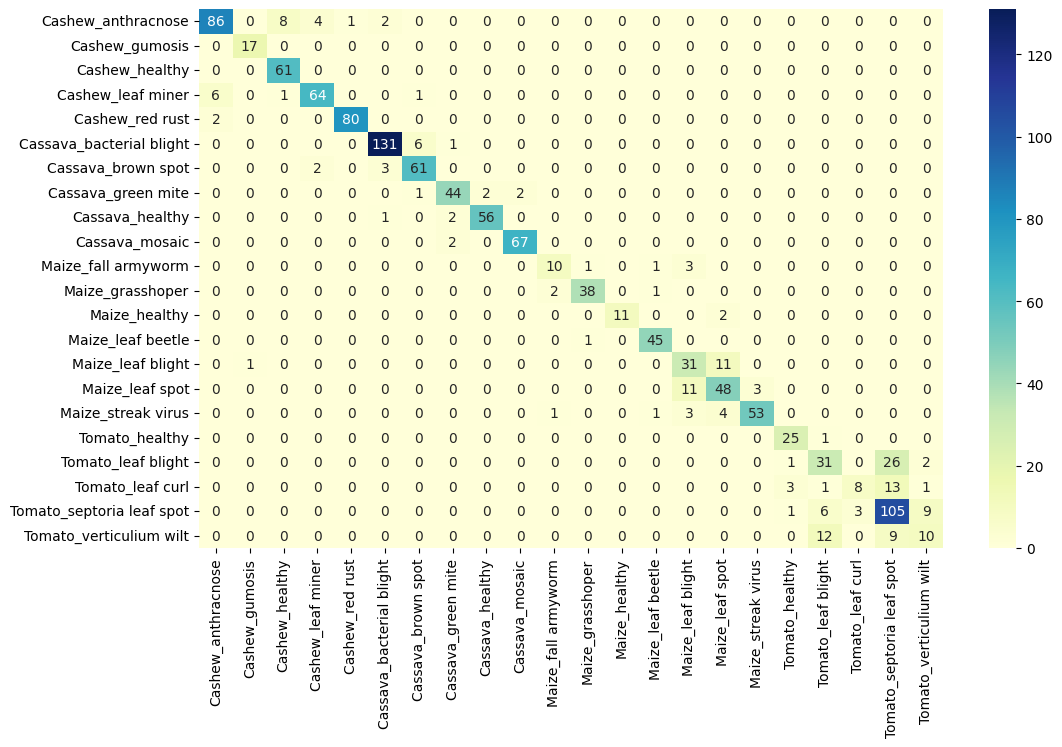

In [124]:
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = classes,
                     columns = classes)
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True,fmt='d', cmap='YlGnBu')
plt.savefig('output.png')